# Traffic Light Detection and Classification - Udacity CarND Capstone
Using a pre-trained model to detect objects in an image.

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

## Object detection imports

Here are the imports from the object detection module.

In [2]:
!ln -s /tf_models/research/object_detection .

In [3]:
!ls

TrafficLightDetection-Inference.ipynb  floydrun.sh	 run.sh
floyd_requirements.txt		       label_map.pbtxt	 test-images-sim
floydrun-export.sh		       object_detection
floydrun-notebook.sh		       run-export.sh


In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Model preparation

In [19]:
ssd_inception_sim_model = '/frozen-graph/frozen_inference_graph.pb'

PATH_TO_LABELS = 'label_map.pbtxt'

NUM_CLASSES = 4

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 2, we know that this corresponds to Red. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [20]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [21]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [22]:
from glob import glob

## Detection

## 1. Testing SSD Inception Models

### 1.1 Testing model trained on simulator on simulator images

In [23]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(ssd_inception_sim_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [24]:
PATH_TO_TEST_IMAGES_DIR = 'test-images-sim'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

test-images-sim/*.jpg
Length of test images: 12


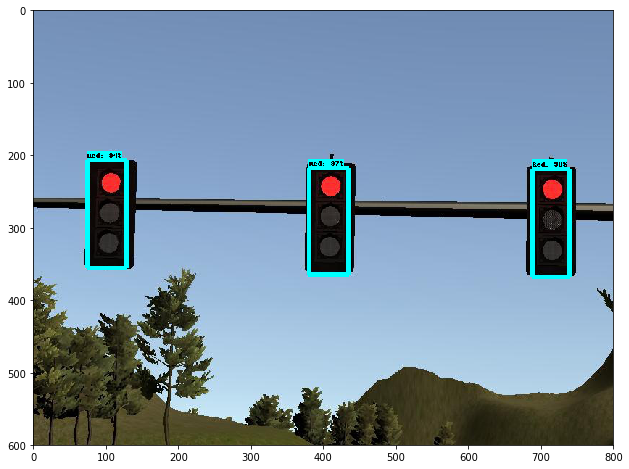

Red 0.985073
Distance (metres) 0.0
Time in milliseconds 945.0502395629883 

Red 0.974629
Distance (metres) 0.0
Time in milliseconds 945.0502395629883 

Red 0.948204
Distance (metres) 0.0
Time in milliseconds 945.0502395629883 



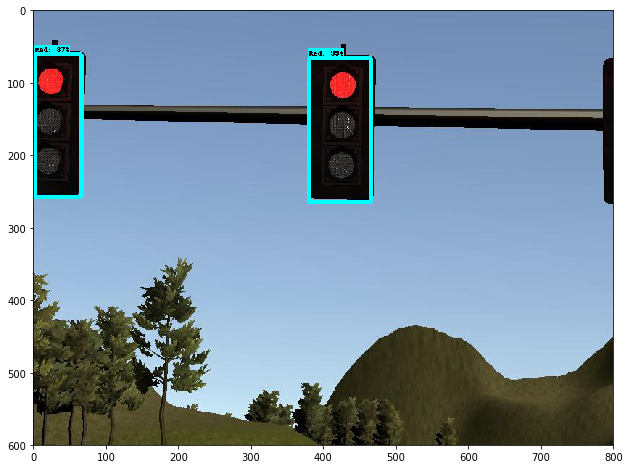

Red 0.996028
Distance (metres) 0.0
Time in milliseconds 188.34567070007324 

Red 0.872042
Distance (metres) 0.0
Time in milliseconds 188.34567070007324 



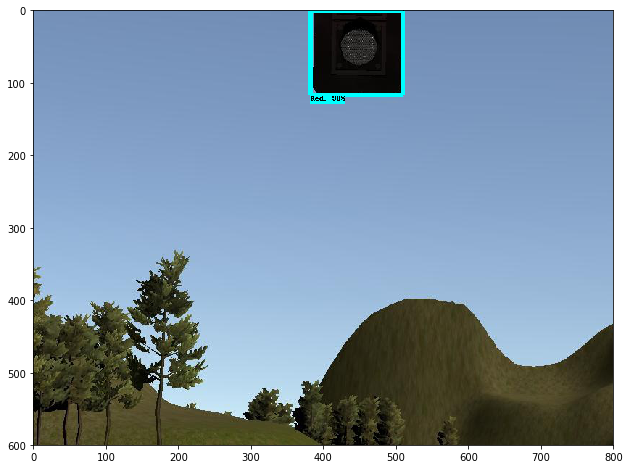

Red 0.9886
Distance (metres) 0.0
Time in milliseconds 163.8469696044922 



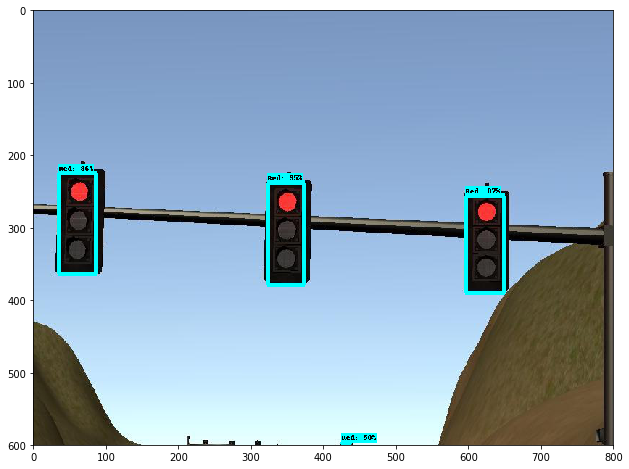

Red 0.96873
Distance (metres) 0.0
Time in milliseconds 165.79127311706543 

Red 0.951085
Distance (metres) 0.0
Time in milliseconds 165.79127311706543 

Red 0.875899
Distance (metres) 0.0
Time in milliseconds 165.79127311706543 

Red 0.509928
Distance (metres) 0.0
Time in milliseconds 165.79127311706543 



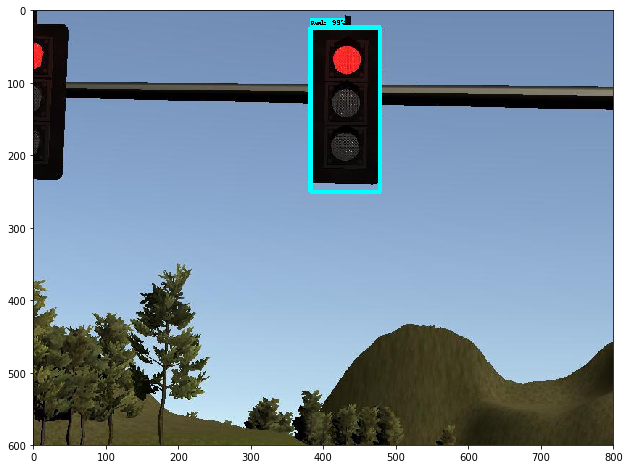

Red 0.997895
Distance (metres) 0.0
Time in milliseconds 165.08769989013672 



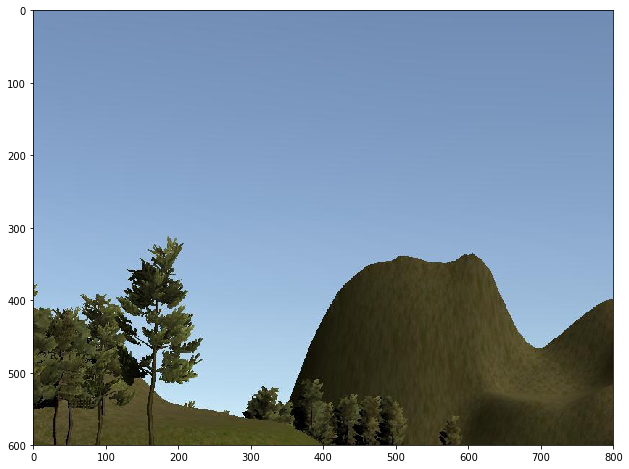

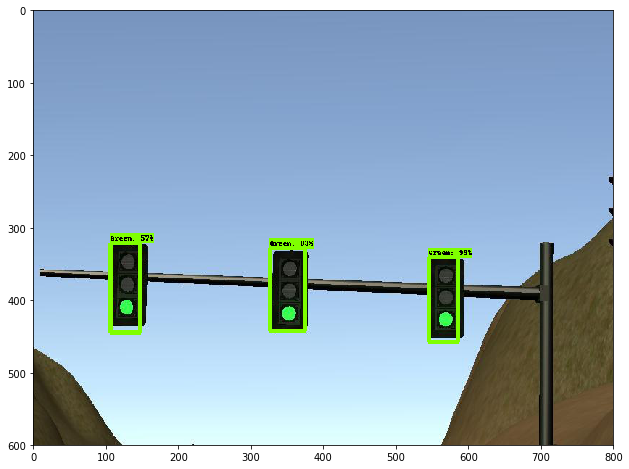

Green 0.998398
Distance (metres) 0.0
Time in milliseconds 162.97173500061035 

Green 0.837384
Distance (metres) 0.0
Time in milliseconds 162.97173500061035 

Green 0.575746
Distance (metres) 0.0
Time in milliseconds 162.97173500061035 



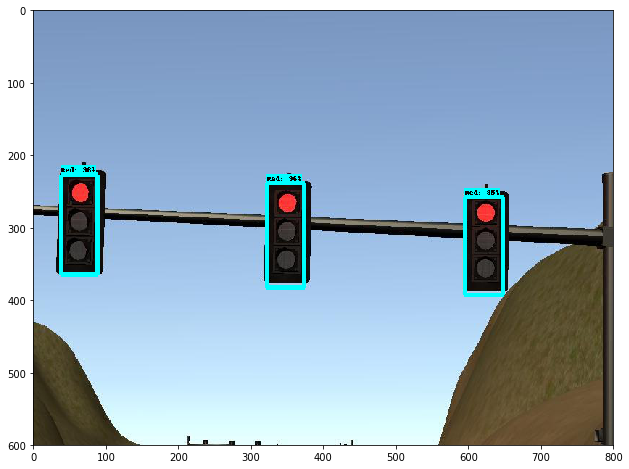

Red 0.967064
Distance (metres) 0.0
Time in milliseconds 164.37220573425293 

Red 0.96529
Distance (metres) 0.0
Time in milliseconds 164.37220573425293 

Red 0.951244
Distance (metres) 0.0
Time in milliseconds 164.37220573425293 



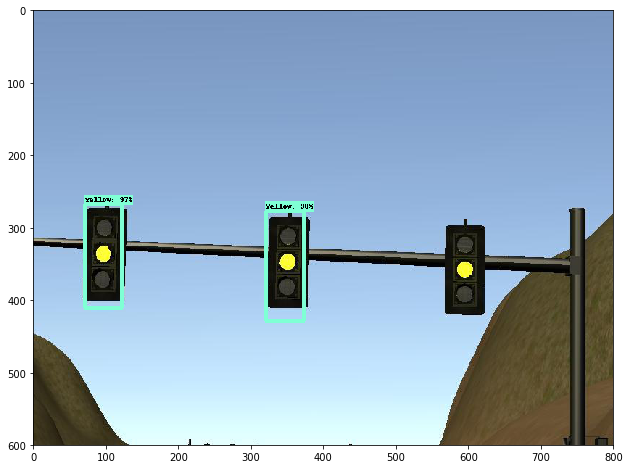

Yellow 0.988836
Distance (metres) 0.0
Time in milliseconds 163.4960174560547 

Yellow 0.97799
Distance (metres) 0.0
Time in milliseconds 163.4960174560547 



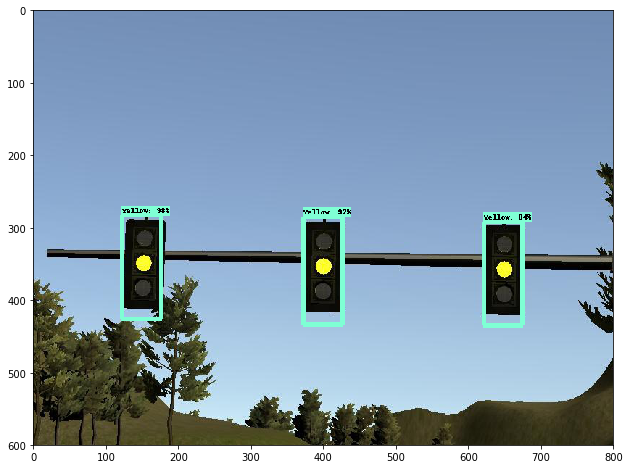

Yellow 0.980347
Distance (metres) 0.0
Time in milliseconds 162.92095184326172 

Yellow 0.975528
Distance (metres) 0.0
Time in milliseconds 162.92095184326172 

Yellow 0.841209
Distance (metres) 0.0
Time in milliseconds 162.92095184326172 



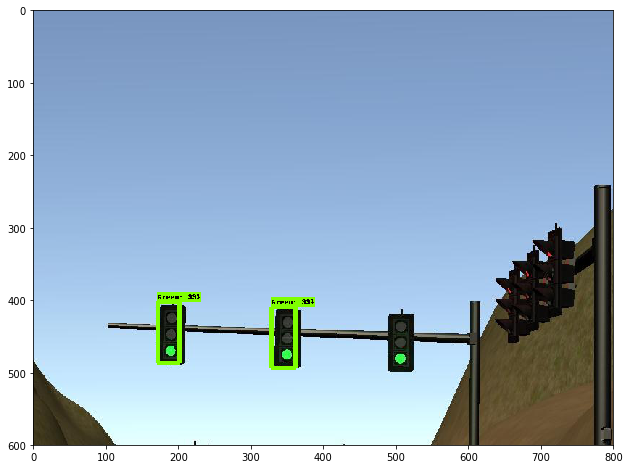

Green 0.99632
Distance (metres) 0.0
Time in milliseconds 162.81700134277344 

Green 0.994947
Distance (metres) 0.0
Time in milliseconds 162.81700134277344 



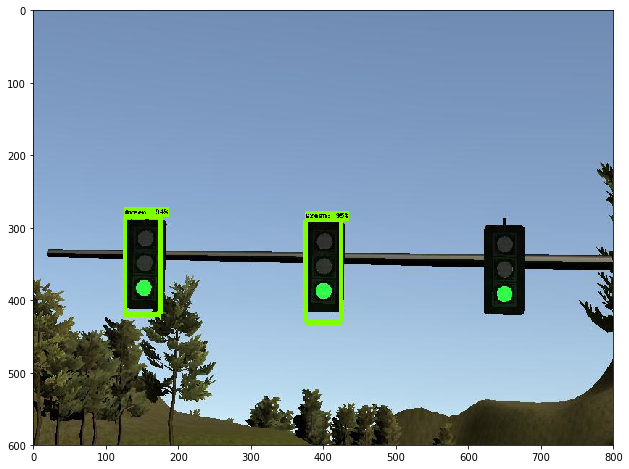

Green 0.950706
Distance (metres) 0.0
Time in milliseconds 161.52644157409668 

Green 0.949422
Distance (metres) 0.0
Time in milliseconds 161.52644157409668 



In [25]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n") 